# Mortgage Data Analysis and Modeling

Shouyu Wang 2024

# Table of Contents:

1.Imports

2.Data Loading

3.Data Cleaning

4.Data Visualization

5.Mortgage Rates Data

6.Mortgage Rate Calculations

7.Delinquency Analysis

8.Machine Learning Model

9.Model Evaluation

10.Feature Importance

11.Visualizing Predictions

12.GUI for Mortgage Recommendations

13.Loan Lookup and Delinquency Check


# Imports

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, 
    f1_score, roc_auc_score, confusion_matrix, classification_report, 
    roc_curve, auc, precision_recall_curve
)
import seaborn as sns
import tkinter as tk

# Data Loading:

Define the file paths and column names, then load the data into pandas DataFrames.

In [28]:
# File paths
file_path_2008 = "/Users/sophiaaa/Desktop/Data File_2008_2020_2022/Monthly Performance Data File_2008.txt"
file_path_2020 = "/Users/sophiaaa/Desktop/Data File_2008_2020_2022/Monthly Performance Data File_2020.txt"
file_path_2022 = "/Users/sophiaaa/Desktop/Data File_2008_2020_2022/Monthly Performance Data File_2022.txt"

# Define column names
column_names = [
    "LOAN SEQUENCE NUMBER", "MONTHLY REPORTING PERIOD", "CURRENT ACTUAL UPB", 
    "CURRENT LOAN DELINQUENCY STATUS", "LOAN AGE", "REMAINING MONTHS TO LEGAL MATURITY",
    "DEFECT SETTLEMENT DATE", "MODIFICATION FLAG", "ZERO BALANCE CODE", 
    "ZERO BALANCE EFFECTIVE DATE", "CURRENT INTEREST RATE", "CURRENT DEFERRED UPB",
    "DUE DATE OF LAST PAID INSTALLMENT(DDLPI)", "MI RECOVERIES", "NET SALE PROCEEDS", 
    "NON MI RECOVERIES", "EXPENSES", "LEGAL COSTS", "MAINTENANCE AND PRESERVATION COSTS", 
    "TAXES AND INSURANCE", "MISCELLANEOUS EXPENSES", "ACTUAL LOSS CALCULATION", 
    "MODIFICATION COST", "STEP MODIFICATION FLAG","DEFERRED PAYMENT PLAN", 
    "ESTIMATED LOAN TO VALUE (ELTV)","ZERO BALANCE REMOVAL UPB","DELINQUENT ACCRUED INTEREST", 
    "DELINQUENCY DUE TO DISASTER","BORROWER ASSISTANCE STATUS CODE","CURRENT MONTH MODIFICATION COST",
    "INTEREST BEARING UPB"
]

# Read the data into DataFrames
def read_data(file_path):
    return pd.read_csv(file_path, sep="|", names=column_names, dtype=str, skiprows=1)

data_2008 = read_data(file_path_2008)
data_2020 = read_data(file_path_2020)
data_2022 = read_data(file_path_2022)

# Data Cleaning:

Standardize column names to lowercase and drop empty columns.

In [29]:
# Standardize column names to lowercase for consistency
data_2008.columns = data_2008.columns.str.lower()
data_2020.columns = data_2020.columns.str.lower()
data_2022.columns = data_2022.columns.str.lower()

# Drop empty columns
data_2008 = data_2008.dropna(axis=1, how='all')
data_2020 = data_2020.dropna(axis=1, how='all')
data_2022 = data_2022.dropna(axis=1, how='all')

# Display the last few rows of the 2008 DataFrame to verify import
print("Data 2008 Preview:")
print(data_2008.tail())

Data 2008 Preview:
        loan sequence number monthly reporting period current actual upb  \
2414318         F08Q40225716                   202211           87834.93   
2414319         F08Q40225716                   202212           87478.33   
2414320         F08Q40225716                   202301           87120.62   
2414321         F08Q40225716                   202302           86761.79   
2414322         F08Q40225716                   202303           86401.84   

        current loan delinquency status loan age  \
2414318                               0      129   
2414319                               0      130   
2414320                               0      131   
2414321                               0      132   
2414322                               0      133   

        remaining months to legal maturity defect settlement date  \
2414318                                192                    NaN   
2414319                                191                    NaN   
2414

# Data Visuallization:

Define functions to visualize various aspects of the mortgage data.

In [30]:
def plot_loan_delinquency_status(data, num_bars=10, y_limit=40000):
    """Plots the distribution of loan delinquency status."""
    try:
        status_counts = data['current loan delinquency status'].value_counts()
        plt.figure(figsize=(12, 6))
        bars = plt.bar(status_counts.index[:num_bars], status_counts.values[:num_bars])
        plt.xlabel('Loan Delinquency Status')
        plt.ylabel('Count')
        plt.title('Distribution of Loan Delinquency Status')
        plt.ylim(0, y_limit)
        plt.xticks(rotation=45)
        for bar in bars:
            height = bar.get_height()
            plt.annotate(f'{height}',
                         xy=(bar.get_x() + bar.get_width() / 2, height),
                         xytext=(0, 3),
                         textcoords="offset points",
                         ha='center', va='bottom')
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error plotting loan delinquency status: {e}")

def plot_top_interest_rates(data, num_interest_rates=15, bar_width=0.6):
    """Plots the top interest rates by frequency."""
    try:
        interest_rates = pd.to_numeric(data['current interest rate'], errors='coerce')
        interest_rate_counts = interest_rates.value_counts().sort_values(ascending=False).head(num_interest_rates)
        plt.figure(figsize=(12, 6))
        x_coords = np.arange(len(interest_rate_counts))
        plt.bar(x_coords, interest_rate_counts.values, width=bar_width,
                color='skyblue', edgecolor='black', alpha=0.7)
        plt.xlabel('Interest Rate (%)')
        plt.ylabel('Frequency')
        plt.title(f'Top {num_interest_rates} Interest Rates by Frequency')
        for x, count in zip(x_coords, interest_rate_counts.values):
            plt.text(x, count + 0.5, f'{int(count)}', ha='center', va='bottom')
        plt.xticks(x_coords, interest_rate_counts.index, rotation=45, ha='center')
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error plotting top interest rates: {e}")

def plot_loan_age_distribution(data, bins=30):
    """Plots the distribution of loan ages using a histogram."""
    try:
        loan_age = pd.to_numeric(data['loan age'], errors='coerce')
        plt.figure(figsize=(12, 6))
        plt.hist(loan_age.dropna(), bins=bins, color='skyblue', edgecolor='black', alpha=0.7)
        plt.xlabel('Loan Age (Months)')
        plt.ylabel('Frequency')
        plt.title('Distribution of Loan Ages')
        plt.xticks(rotation=45)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error plotting loan age distribution: {e}")

def plot_estimated_ltv_distribution(data):
    """Plots the distribution of Estimated Loan to Value (ELTV), excluding invalid values."""
    try:
        data['estimated loan to value (eltv)'] = pd.to_numeric(data['estimated loan to value (eltv)'], errors='coerce')
        filtered_eltv = data[data['estimated loan to value (eltv)'] != 999]['estimated loan to value (eltv)']
        eltv_counts = filtered_eltv.value_counts().sort_index()
        plt.figure(figsize=(12, 6))
        plt.bar(eltv_counts.index, eltv_counts.values, color='blue', alpha=0.7)
        plt.xlabel('Estimated LTV (%)')
        plt.ylabel('Frequency')
        plt.title('Distribution of Estimated LTV (Excluding 999%)')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error plotting estimated LTV distribution: {e}")

Plotting for Each Dataset:


Plotting for 2008:


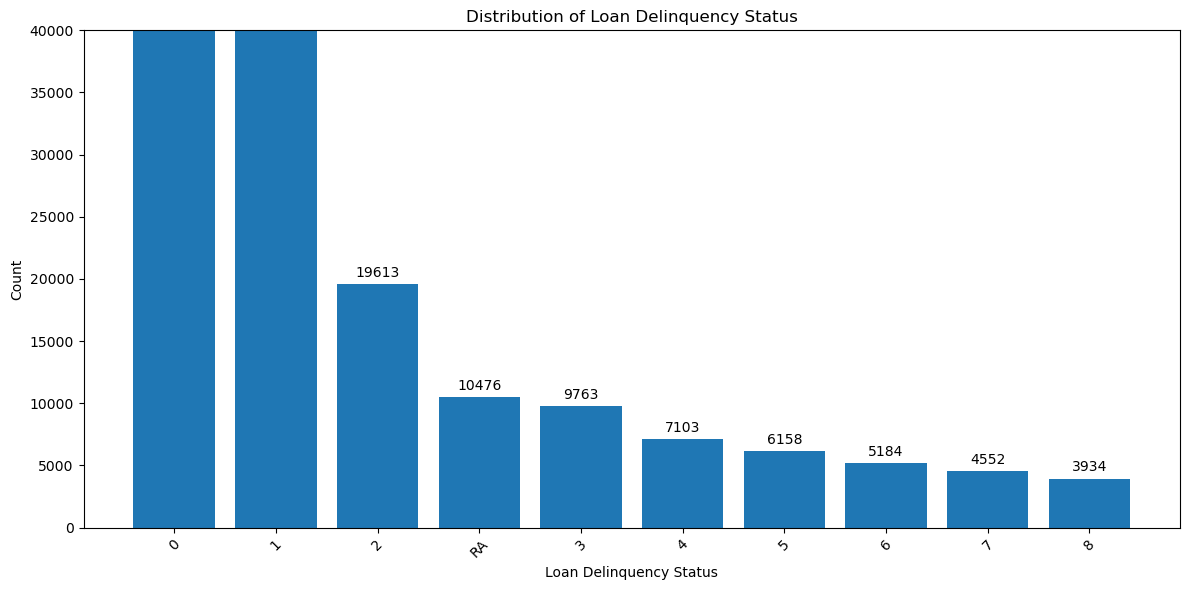

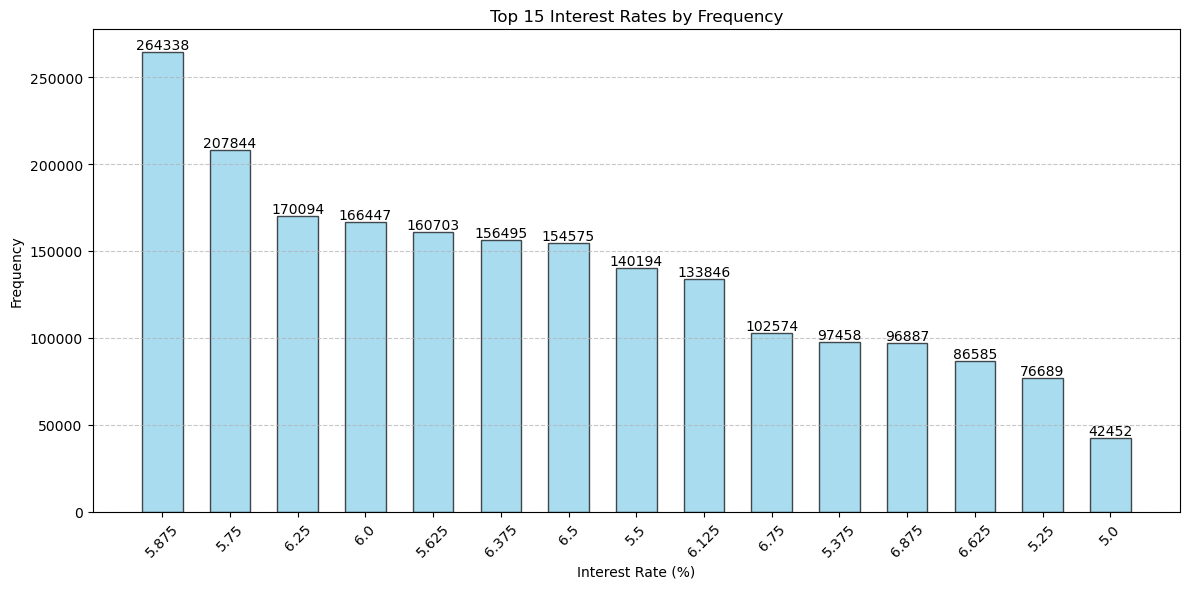

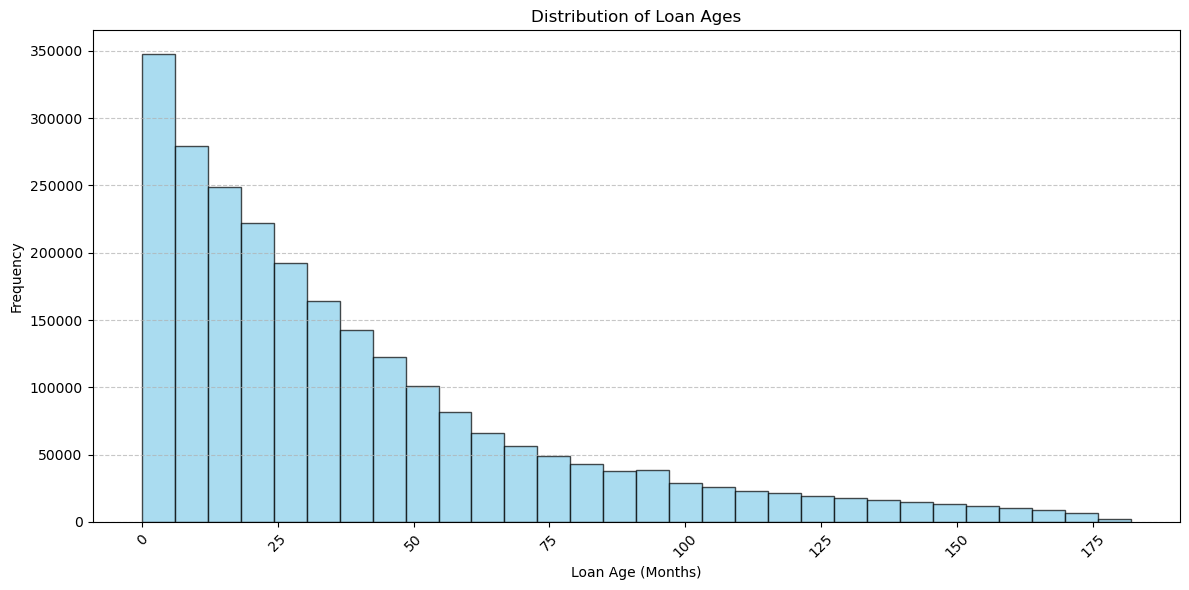

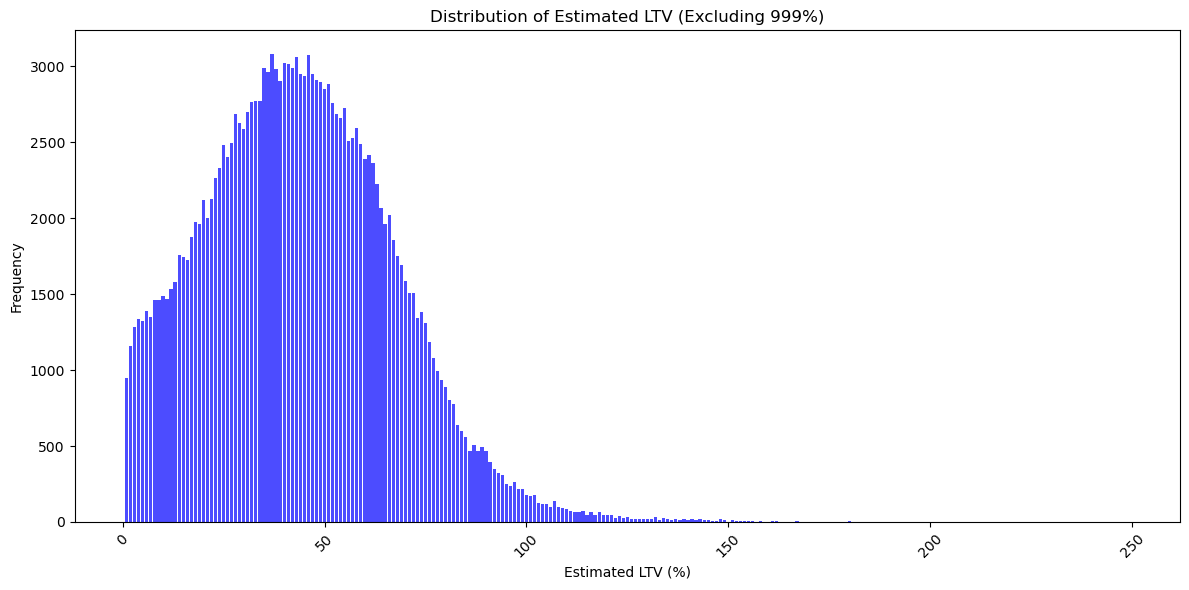


Plotting for 2020:


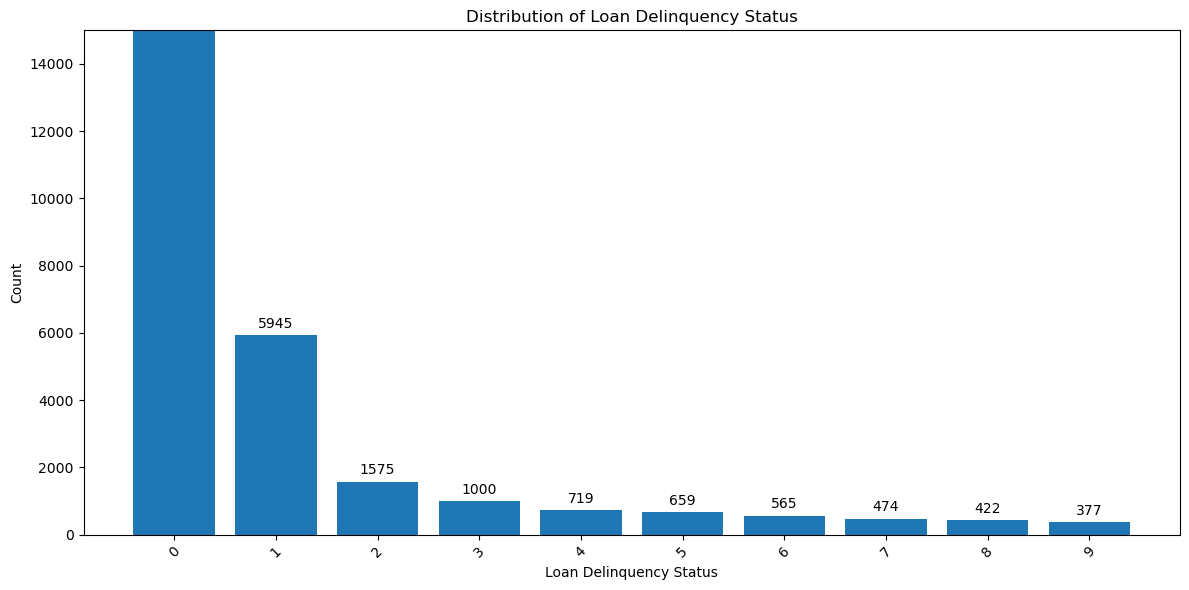

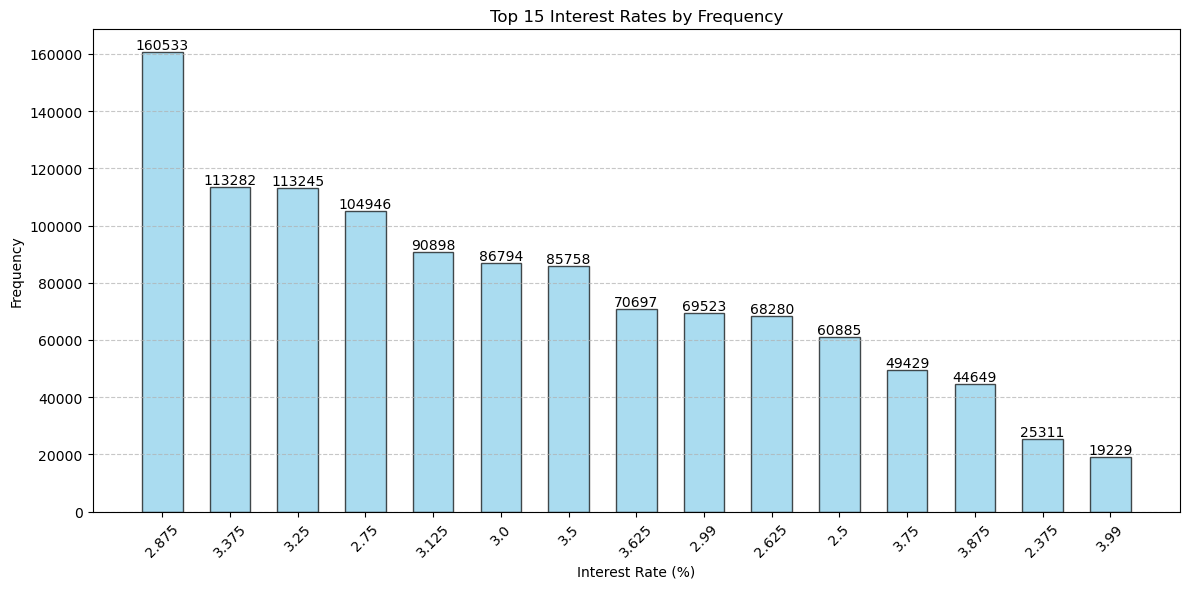

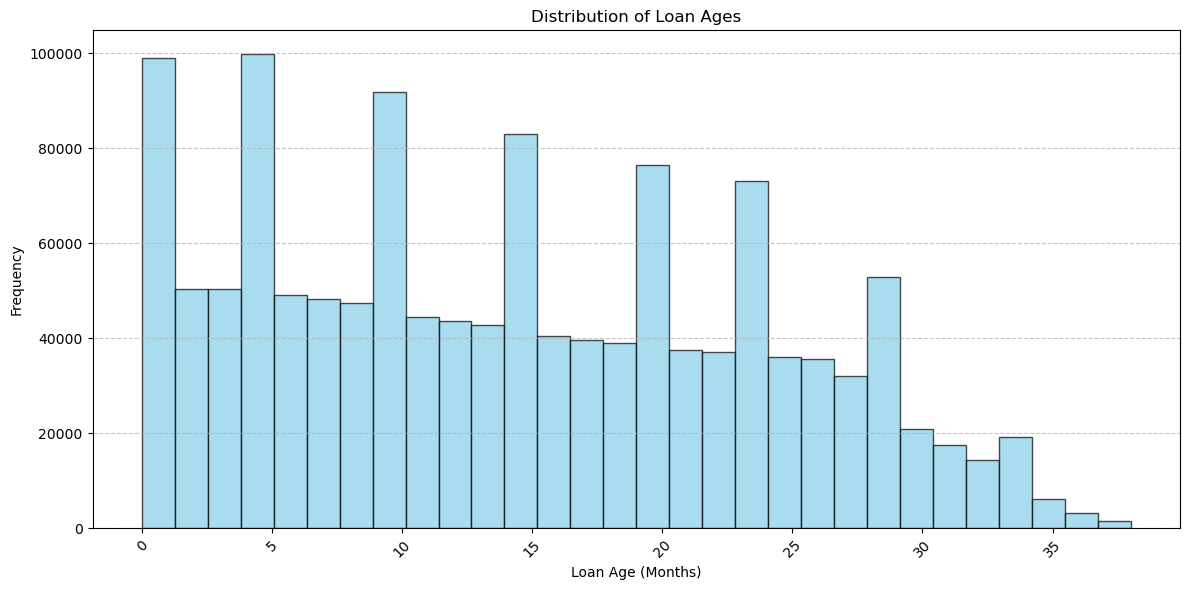

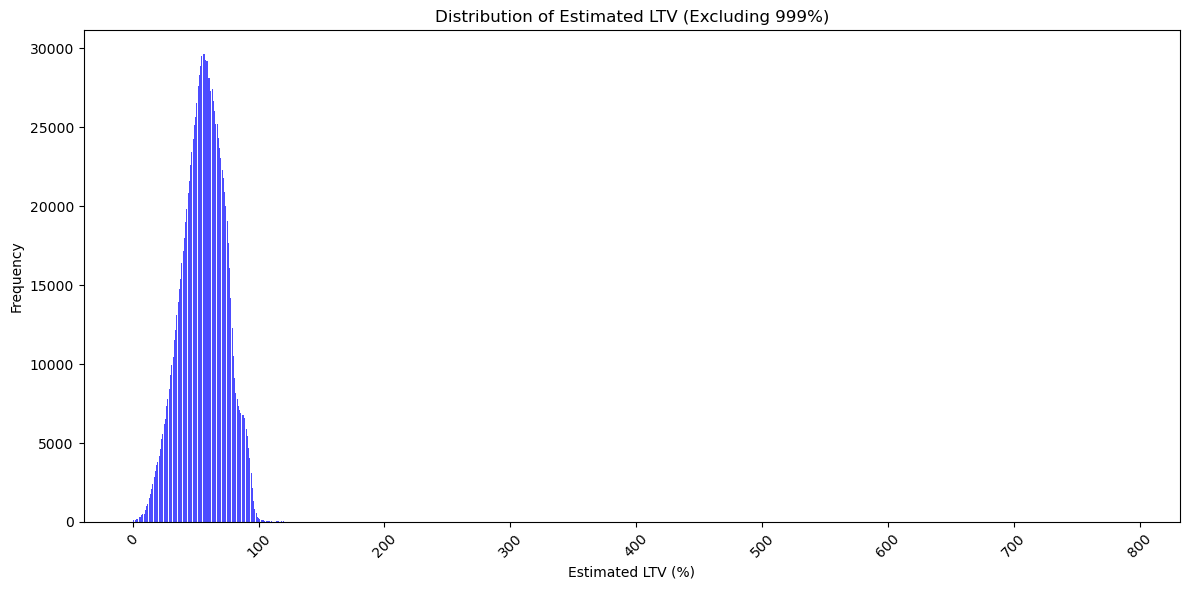


Plotting for 2022:


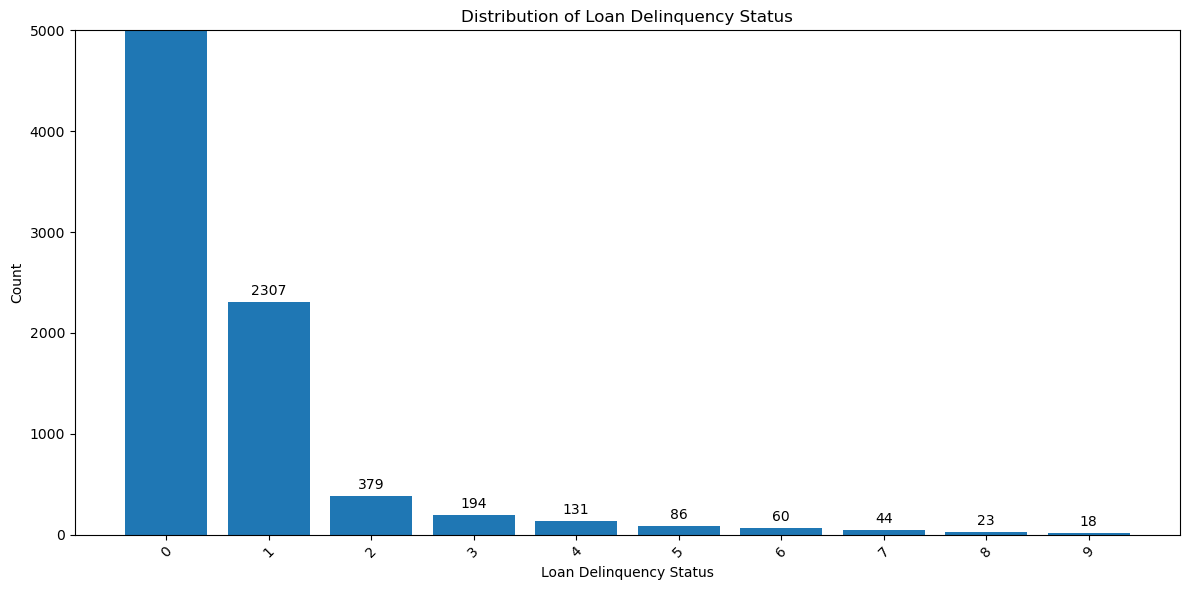

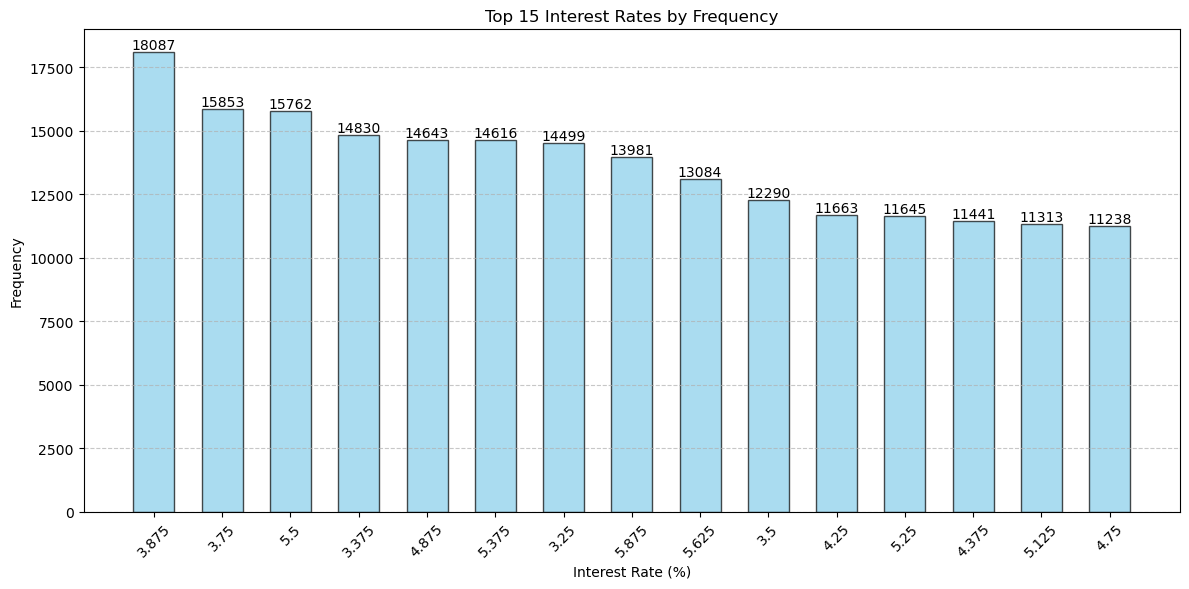

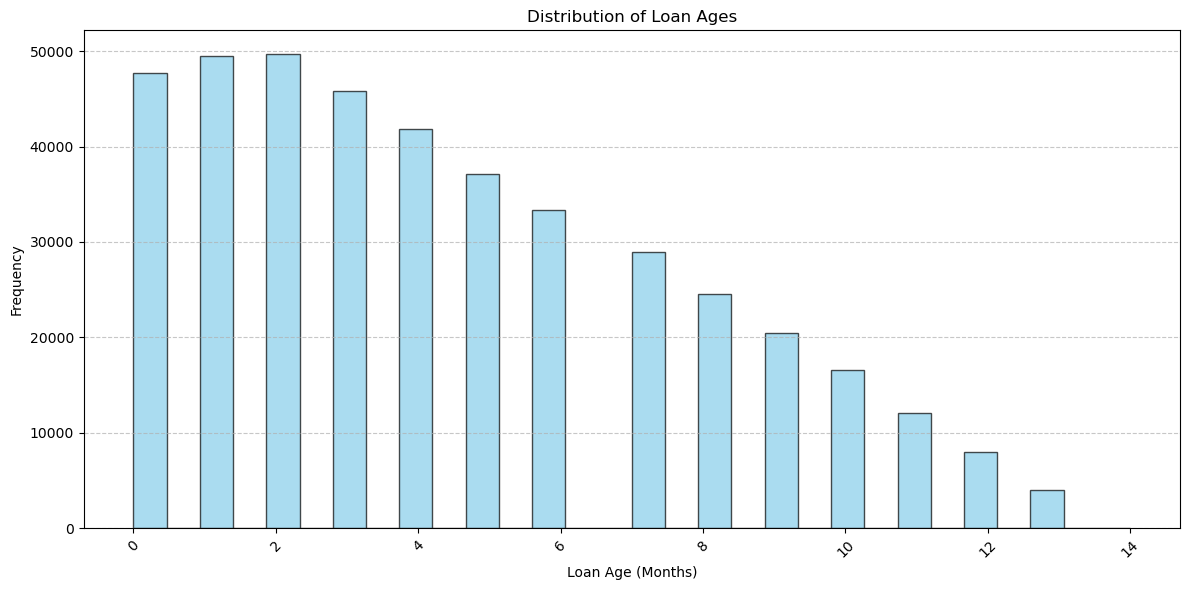

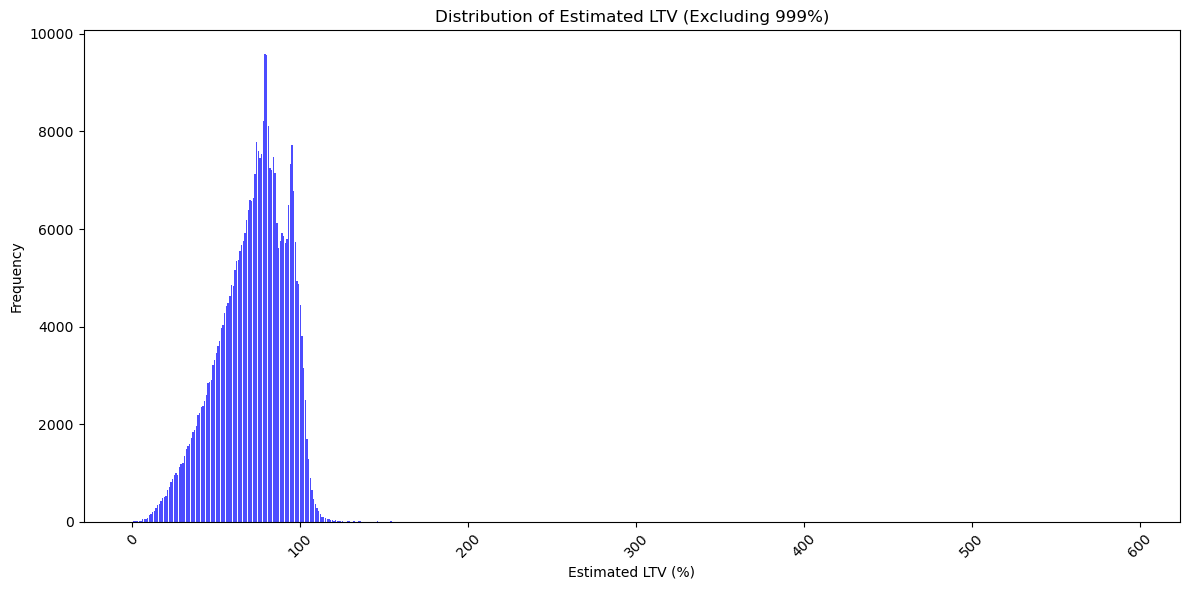

In [31]:
# Plotting functions for each dataset
datasets = {
    '2008': data_2008,
    '2020': data_2020,
    '2022': data_2022
}

for year, df in datasets.items():
    print(f"\nPlotting for {year}:")
    if year == '2008':
        y_limit = 40000
    elif year == '2020':
        y_limit = 15000
    else:
        y_limit = 5000
    plot_loan_delinquency_status(df, num_bars=10, y_limit=y_limit)
    plot_top_interest_rates(df, num_interest_rates=15, bar_width=0.6)
    plot_loan_age_distribution(df, bins=30)
    plot_estimated_ltv_distribution(df)

Mortgage Rates Data:

In [32]:
# Define mortgage rates based on provided content
# Mortgage News Daily Rates as of 11/29/2024
mortgage_rates = {
    '30Yr Fixed Rate': 6.88,
    '15Yr Fixed Rate': 6.09,
    '30Yr Jumbo': 7.05,
    '7/6 SOFR ARM': 6.82,
    '30Yr FHA': 6.22,
    '30Yr VA': 6.24
}

print("Today's Mortgage Rates:")
for rate_type, rate in mortgage_rates.items():
    print(f"{rate_type}: {rate}%")

Today's Mortgage Rates:
30Yr Fixed Rate: 6.88%
15Yr Fixed Rate: 6.09%
30Yr Jumbo: 7.05%
7/6 SOFR ARM: 6.82%
30Yr FHA: 6.22%
30Yr VA: 6.24%


# Mortgage Rate Calculations:

Combine DataFrames and calculate mortgage-related metrics.

In [33]:
# Combine DataFrames
combined_df = pd.concat([data_2008, data_2020, data_2022], axis=0, ignore_index=True)
combined_df.sort_values(by='monthly reporting period', ascending=False, inplace=True)
combined_df.drop_duplicates(subset='loan sequence number', keep='first', inplace=True)
combined_df.reset_index(drop=True, inplace=True)

print("\nCombined Data Preview:")
print(combined_df.head())


Combined Data Preview:
  loan sequence number monthly reporting period current actual upb  \
0         F22Q40221315                   202303          371000.00   
1         F22Q20418931                   202303          254113.13   
2         F20Q10136222                   202303          582592.08   
3         F20Q30210759                   202303          214666.64   
4         F22Q30294223                   202303          136000.00   

  current loan delinquency status loan age remaining months to legal maturity  \
0                               0      003                                357   
1                               0      008                                352   
2                               0      036                                324   
3                               0      031                                329   
4                               0      006                                174   

  defect settlement date modification flag zero balance code  \
0   

In [34]:
# Create a new DataFrame with selected columns
selected_columns = [
    'loan sequence number', 'current actual upb', 'loan age', 
    'remaining months to legal maturity', 'current interest rate', 
    'current month modification cost'
]
new_df = combined_df[selected_columns].copy()

# Convert columns to numeric, handling non-numeric entries
new_df = new_df.apply(pd.to_numeric, errors='coerce').fillna(0)
print("\nNew DataFrame Preview:")
print(new_df.head())


New DataFrame Preview:
   loan sequence number  current actual upb  loan age  \
0                   0.0           371000.00         3   
1                   0.0           254113.13         8   
2                   0.0           582592.08        36   
3                   0.0           214666.64        31   
4                   0.0           136000.00         6   

   remaining months to legal maturity  current interest rate  \
0                                 357                  7.125   
1                                 352                  6.500   
2                                 324                  3.750   
3                                 329                  3.250   
4                                 174                  4.000   

   current month modification cost  
0                              0.0  
1                              0.0  
2                              0.0  
3                              0.0  
4                              0.0  


In [35]:
# Assign mortgage rates from the predefined data
rate_15yr = mortgage_rates.get('15Yr Fixed Rate', 6.09)
rate_30yr = mortgage_rates.get('30Yr Fixed Rate', 6.88)

print("\nUsing predefined mortgage rates:")
print(f"30 Yr. Fixed Mortgage Rate: {rate_30yr}%")
print(f"15 Yr. Fixed Mortgage Rate: {rate_15yr}%")


Using predefined mortgage rates:
30 Yr. Fixed Mortgage Rate: 6.88%
15 Yr. Fixed Mortgage Rate: 6.09%


In [36]:
# Calculate the mortgage rate for each loan
new_df['total_term_months'] = new_df['loan age'].astype(int) + new_df['remaining months to legal maturity'].astype(int)

conditions = [
    (new_df['total_term_months'] > 0) & (new_df['total_term_months'] <= 180),
    (new_df['total_term_months'] > 180)
]
choices = [rate_15yr, rate_30yr]
new_df['current mortgage rate'] = np.select(conditions, choices, default=rate_30yr)

In [37]:
def calculate_monthly_payment(interest_rate, remaining_months, loan_balance):
    """Calculates the monthly payment for a loan."""
    try:
        monthly_interest_rate = (interest_rate / 100) / 12
        if monthly_interest_rate == 0:
            return loan_balance / remaining_months if remaining_months > 0 else 0
        monthly_payment = loan_balance * (monthly_interest_rate * (1 + monthly_interest_rate) ** remaining_months) / ((1 + monthly_interest_rate) ** remaining_months - 1)
        return monthly_payment
    except Exception as e:
        print(f"Error calculating monthly payment: {e}")
        return 0

In [38]:
# Calculate payments and potential savings
new_df['current_payments'] = new_df.apply(
    lambda row: calculate_monthly_payment(row['current interest rate'], row['remaining months to legal maturity'], row['current actual upb']),
    axis=1
)
new_df['best_payments'] = new_df.apply(
    lambda row: calculate_monthly_payment(row['current mortgage rate'], row['remaining months to legal maturity'], row['current actual upb']),
    axis=1
)
new_df['potential_savings'] = new_df['current_payments'] - new_df['best_payments']

/var/folders/k3/kf8yp5mx5pb3kddlj6lnm5nr0000gn/T/ipykernel_12194/1378068270.py:7: RuntimeWarning: invalid value encountered in scalar divide
  monthly_payment = loan_balance * (monthly_interest_rate * (1 + monthly_interest_rate) ** remaining_months) / ((1 + monthly_interest_rate) ** remaining_months - 1)
/var/folders/k3/kf8yp5mx5pb3kddlj6lnm5nr0000gn/T/ipykernel_12194/1378068270.py:7: RuntimeWarning: invalid value encountered in scalar divide
  monthly_payment = loan_balance * (monthly_interest_rate * (1 + monthly_interest_rate) ** remaining_months) / ((1 + monthly_interest_rate) ** remaining_months - 1)


In [39]:
# Calculate breakeven points
new_df['breakeven_months'] = new_df.apply(
    lambda row: row['current month modification cost'] / row['potential_savings'] 
    if row['potential_savings'] > 0 else np.nan, axis=1
)
new_df['breakeven_months'].replace([np.inf, -np.inf], np.nan, inplace=True)  # Handle division by zero
new_df['breakeven_months'].fillna(0, inplace=True)

In [40]:
# Determine if refinancing is beneficial
new_df['beneficial'] = new_df['potential_savings'].apply(lambda x: "Yes" if x > 0 else "No")

print("\nData with Mortgage Calculations:")
print(new_df.head())


Data with Mortgage Calculations:
   loan sequence number  current actual upb  loan age  \
0                   0.0           371000.00         3   
1                   0.0           254113.13         8   
2                   0.0           582592.08        36   
3                   0.0           214666.64        31   
4                   0.0           136000.00         6   

   remaining months to legal maturity  current interest rate  \
0                                 357                  7.125   
1                                 352                  6.500   
2                                 324                  3.750   
3                                 329                  3.250   
4                                 174                  4.000   

   current month modification cost  total_term_months  current mortgage rate  \
0                              0.0                360                   6.88   
1                              0.0                360                   6.88  

In [41]:
# Filter beneficial loans
beneficial_rows = new_df[new_df['beneficial'] == 'Yes']
loan_sequence_numbers = beneficial_rows['loan sequence number']
print("\nBeneficial Loan Sequence Numbers:")
print(loan_sequence_numbers.tolist())


Beneficial Loan Sequence Numbers:
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

# Delinquency Analysis

Create and process a delinquency-focused DataFrame.

In [42]:
# Create a delinquency DataFrame
selected_columns_1 = [
    'loan sequence number','current loan delinquency status', 'loan age', 
    'remaining months to legal maturity', 'current interest rate',
    'estimated loan to value (eltv)','delinquent accrued interest',
    'delinquency due to disaster','borrower assistance status code',
    'current month modification cost','interest bearing upb'
]
df_dlq = combined_df[selected_columns_1].copy()
df_dlq = df_dlq.apply(pd.to_numeric, errors='coerce').fillna(0)
print("\nDelinquency DataFrame Preview:")
print(df_dlq.head())


Delinquency DataFrame Preview:
   loan sequence number  current loan delinquency status  loan age  \
0                   0.0                              0.0         3   
1                   0.0                              0.0         8   
2                   0.0                              0.0        36   
3                   0.0                              0.0        31   
4                   0.0                              0.0         6   

   remaining months to legal maturity  current interest rate  \
0                                 357                  7.125   
1                                 352                  6.500   
2                                 324                  3.750   
3                                 329                  3.250   
4                                 174                  4.000   

   estimated loan to value (eltv)  delinquent accrued interest  \
0                           999.0                          0.0   
1                            8

In [43]:
# Examine the Distribution
delinquency_counts = df_dlq['current loan delinquency status'].value_counts()
print("\nDelinquency Counts:")
print(delinquency_counts)


Delinquency Counts:
0.0      147146
2.0         583
1.0         546
3.0         150
4.0         113
          ...  
71.0          1
68.0          1
70.0          1
108.0         1
101.0         1
Name: current loan delinquency status, Length: 90, dtype: int64


In [44]:
# Define delinquency threshold
delinquency_threshold = 5

# Create a boolean mask to exclude 'RA'
mask = combined_df['current loan delinquency status'] != 'RA'
df_dlq = df_dlq[mask]

# Replace 'Y' with '1' in 'Delinquency due to disaster'
df_dlq['delinquency due to disaster'] = df_dlq['delinquency due to disaster'].replace('Y', 1).astype(int)

# Create a binary target variable
df_dlq['delinquency'] = (df_dlq['current loan delinquency status'].astype(int) >= delinquency_threshold).astype(int)

print("\nProcessed Delinquency DataFrame:")
print(df_dlq.head())


Processed Delinquency DataFrame:
   loan sequence number  current loan delinquency status  loan age  \
0                   0.0                              0.0         3   
1                   0.0                              0.0         8   
2                   0.0                              0.0        36   
3                   0.0                              0.0        31   
4                   0.0                              0.0         6   

   remaining months to legal maturity  current interest rate  \
0                                 357                  7.125   
1                                 352                  6.500   
2                                 324                  3.750   
3                                 329                  3.250   
4                                 174                  4.000   

   estimated loan to value (eltv)  delinquent accrued interest  \
0                           999.0                          0.0   
1                           

# Machine Learning Model

Prepare data for modeling and train a Random Forest classifier.

In [45]:
# Define features and target variable
selected_features = [
    'current loan delinquency status', 'loan age', 
    'remaining months to legal maturity', 'current interest rate', 
    'current month modification cost',
    'estimated loan to value (eltv)', 'delinquent accrued interest',
    'delinquency due to disaster', 'borrower assistance status code',
    'interest bearing upb'
]
X = df_dlq[selected_features].copy()
y = df_dlq['delinquency'].copy()

# Ensure all features are numeric
X = X.apply(pd.to_numeric, errors='coerce').fillna(0)
y = pd.to_numeric(y, errors='coerce').fillna(0)

# Apply SMOTE to handle class imbalance
print("\nClass distribution before SMOTE:")
print(y.value_counts())

smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X, y)

print("\nClass distribution after SMOTE:")
print(pd.Series(y_smote).value_counts())

# Split the data with stratification to maintain class distribution
X_train, X_test, y_train, y_test = train_test_split(
    X_smote, y_smote, test_size=0.2, random_state=42, stratify=y_smote
)

# Verify target distribution in train and test sets
print("\nTraining Target Distribution:")
print(pd.Series(y_train).value_counts())
print("\nTest Target Distribution:")
print(pd.Series(y_test).value_counts())

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Random Forest Classifier on resampled data
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)


Class distribution before SMOTE:
0    147313
1      1453
Name: delinquency, dtype: int64

Class distribution after SMOTE:
0    147313
1    147313
Name: delinquency, dtype: int64

Training Target Distribution:
1    117850
0    117850
Name: delinquency, dtype: int64

Test Target Distribution:
0    29463
1    29463
Name: delinquency, dtype: int64


RandomForestClassifier(random_state=42)

Model Evaluation

Evaluate the trained model using various metrics.

In [46]:
# Make predictions on the test data
y_pred = model.predict(X_test_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, zero_division=0)
recall = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)
roc_auc = roc_auc_score(y_test, y_pred)

# Print evaluation metrics
print("\nModel Evaluation Metrics:")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"ROC AUC Score: {roc_auc:.2f}")


Model Evaluation Metrics:
Accuracy: 1.00
Precision: 1.00
Recall: 1.00
F1 Score: 1.00
ROC AUC Score: 1.00


In [47]:
# Print confusion matrix and classification report for deeper insights
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Confusion Matrix:
[[29463     0]
 [    0 29463]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     29463
           1       1.00      1.00      1.00     29463

    accuracy                           1.00     58926
   macro avg       1.00      1.00      1.00     58926
weighted avg       1.00      1.00      1.00     58926



# Feature Importance:

Analyze which features are most important in predicting delinquency.


Feature Importances:
current loan delinquency status       0.668286
delinquent accrued interest           0.138705
estimated loan to value (eltv)        0.055489
loan age                              0.035339
interest bearing upb                  0.034657
current interest rate                 0.031216
current month modification cost       0.021562
remaining months to legal maturity    0.014746
delinquency due to disaster           0.000000
borrower assistance status code       0.000000
dtype: float64


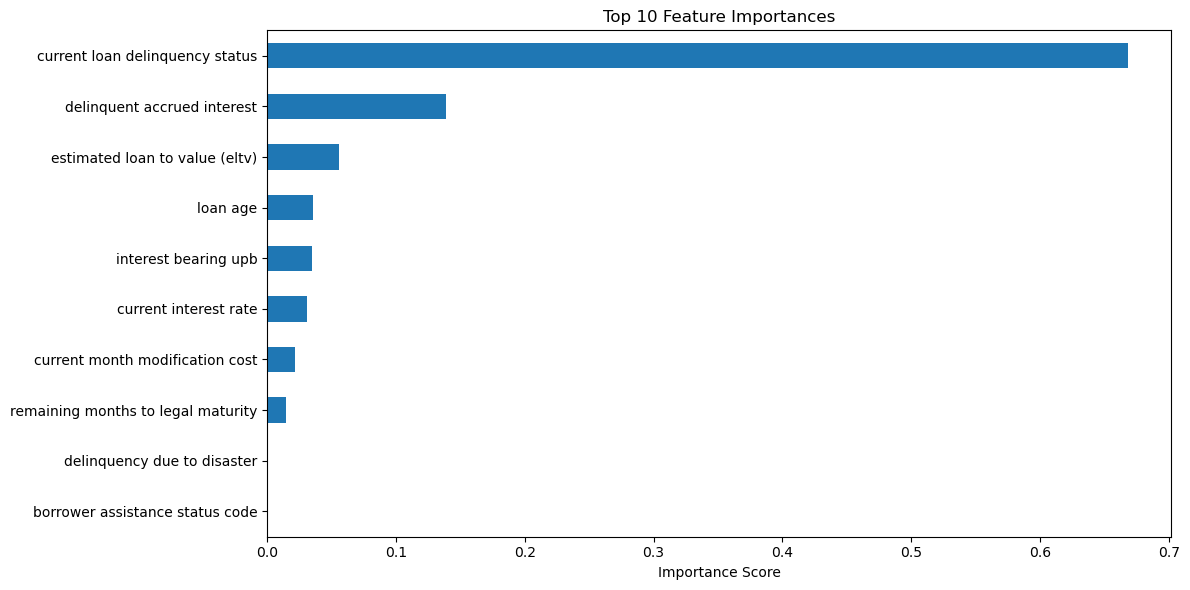

In [48]:
# Analyze Feature Importances
importances = model.feature_importances_
feature_names = X.columns
feature_importances = pd.Series(importances, index=feature_names).sort_values(ascending=False)

print("\nFeature Importances:")
print(feature_importances)

# Plot feature importances
plt.figure(figsize=(12, 6))
feature_importances.head(10).plot(kind='barh')
plt.xlabel('Importance Score')
plt.title('Top 10 Feature Importances')
plt.gca().invert_yaxis()  # Highest importance at the top
plt.tight_layout()
plt.show()

# Visualizing Predictions:

Visualize model performance through various plots.

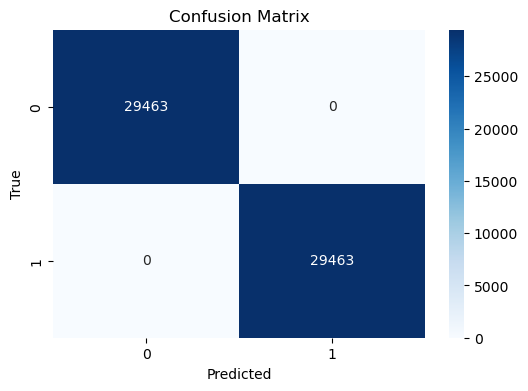

In [49]:
# Confusion Matrix Heatmap
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

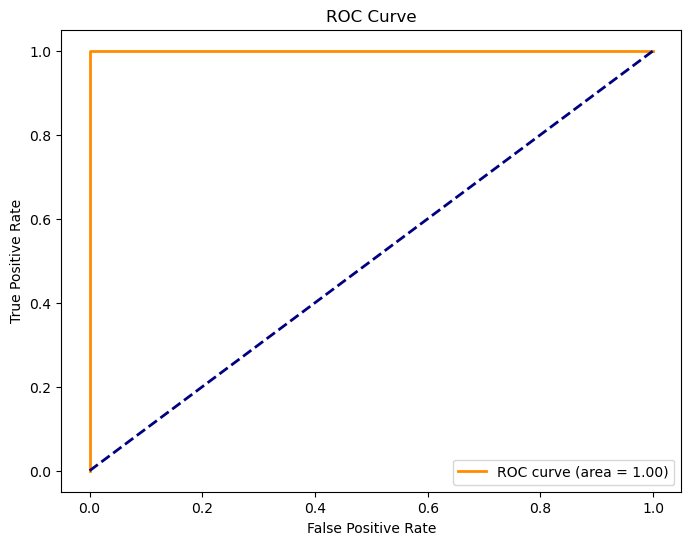

In [50]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test_scaled)[:,1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

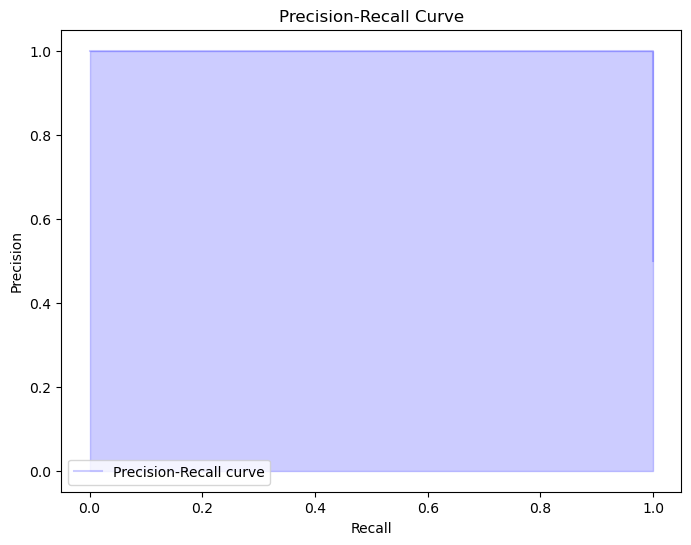

In [51]:
# Precision-Recall Curve
precision_vals, recall_vals, thresholds = precision_recall_curve(y_test, model.predict_proba(X_test_scaled)[:,1])

plt.figure(figsize=(8,6))
plt.step(recall_vals, precision_vals, where='post', color='b', alpha=0.2, label='Precision-Recall curve')
plt.fill_between(recall_vals, precision_vals, step='post', alpha=0.2, color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

# GUI for Mortgage Recommendations

Create a simple GUI using tkinter for mortgage recommendations based on user input.

In [52]:
# Function to calculate recommendations based on input
def calculate_recommendations():
    try:
        current_actual_upb = float(entry_upb.get())
        loan_age = float(entry_age.get())
        remaining_months = float(entry_remaining.get())
        current_interest_rate = float(entry_rate.get())
        current_month_modification_cost = float(entry_cost.get())
    except ValueError:
        recommendation_label.config(text="Invalid input. Please enter numeric values.")
        return

    if loan_age + remaining_months <= 180:
        current_mortgage_rate = rate_15yr
    else:
        current_mortgage_rate = rate_30yr

    # Calculate potential savings for the input data
    current_payment = calculate_monthly_payment(current_interest_rate, remaining_months, current_actual_upb)
    best_payment = calculate_monthly_payment(current_mortgage_rate, remaining_months, current_actual_upb)
    potential_savings = current_payment - best_payment

    # Check if the loan is beneficial
    if potential_savings <= 0:
        recommendation_label.config(text="Not beneficial")
    else:
        breakeven_months = current_month_modification_cost / potential_savings
        recommendation_label.config(text=f"Beneficial with a breakeven period of {breakeven_months:.2f} months")

# Function to calculate monthly payment
def calculate_monthly_payment(interest_rate, remaining_months, loan_balance):
    monthly_interest_rate = (float(interest_rate) / 100) / 12
    if monthly_interest_rate == 0:
        return loan_balance / remaining_months if remaining_months > 0 else 0
    monthly_payment = float(loan_balance) * (monthly_interest_rate * (1 + monthly_interest_rate) ** remaining_months) / ((1 + monthly_interest_rate) ** remaining_months - 1)
    return monthly_payment

# Create the main GUI window
root = tk.Tk()
root.title("Mortgage Recommendation Tool")

# Labels and Entry widgets for user input
label_upb = tk.Label(root, text="Current actual upb:")
label_upb.pack()
entry_upb = tk.Entry(root)
entry_upb.pack()

label_age = tk.Label(root, text="Loan age:")
label_age.pack()
entry_age = tk.Entry(root)
entry_age.pack()

label_remaining = tk.Label(root, text="Remaining months to legal maturity:")
label_remaining.pack()
entry_remaining = tk.Entry(root)
entry_remaining.pack()

label_rate = tk.Label(root, text="Current interest rate:")
label_rate.pack()
entry_rate = tk.Entry(root)
entry_rate.pack()

label_cost = tk.Label(root, text="Current month modification cost:")
label_cost.pack()
entry_cost = tk.Entry(root)
entry_cost.pack()

# Button to calculate recommendations
calculate_button = tk.Button(root, text="Calculate Recommendations", command=calculate_recommendations)
calculate_button.pack()

# Label to display recommendations
recommendation_label = tk.Label(root, text="")
recommendation_label.pack()

# Start the GUI main loop
root.mainloop()

# Loan Lookup and Delinquency Check

Create another GUI to look up loan details and check for delinquency issues.

In [53]:
# Function to look up a loan sequence number and check for delinquency issues
def lookup_loan_sequence():
    sequence_number = entry_sequence.get()
    row = df_dlq[df_dlq['loan sequence number'] == float(sequence_number)]
    if row.empty:
        lookup_label.config(text="Loan sequence number not found in the dataset.")
    else:
        # Display loan information
        info_text = "Loan Information:\n"
        info_text += f"Current loan delinquency status: {row['current loan delinquency status'].values[0]}\n"
        info_text += f"Loan age: {row['loan age'].values[0]}\n"
        info_text += f"Remaining months to legal maturity: {row['remaining months to legal maturity'].values[0]}\n"
        info_text += f"Current interest rate: {row['current interest rate'].values[0]}\n"
        info_text += f"Estimated loan to value (eltv): {row['estimated loan to value (eltv)'].values[0]}\n"
        info_text += f"Delinquent accrued interest: {row['delinquent accrued interest'].values[0]}\n"
        info_text += f"Delinquency due to disaster: {row['delinquency due to disaster'].values[0]}\n"
        info_text += f"Borrower assistance status code: {row['borrower assistance status code'].values[0]}\n"
        info_text += f"Current month modification cost: {row['current month modification cost'].values[0]}\n"
        info_text += f"Interest bearing upb: {row['interest bearing upb'].values[0]}\n"

        # Check for delinquency problems
        potential_delinquency_issue = False
        if row['current loan delinquency status'].values[0] == 1:
            potential_delinquency_issue = True

        if row['estimated loan to value (eltv)'].values[0] >= 50:
            info_text += "The ELTV is quite high, and further consideration should be given.\n"

        if int(row['loan age'].values[0]) >= 110:
            if row['current loan delinquency status'].values[0] >= 10:
                info_text += "It's in the second half of the loan term, the repayment habit is not reliable.\n"
            else:
                info_text += "It's in the second half of the loan term, the repayment habit is good, might not have a huge issue in delinquency.\n"

        if row['delinquency due to disaster'].values[0] == 1:
            info_text += "Customer has delinquency due to disaster, might not have a huge issue in delinquency.\n"

        loan_info_label.config(text=info_text)

        if potential_delinquency_issue:
            delinquency_label.config(text="Potential delinquency issue")
        else:
            delinquency_label.config(text="No potential delinquency issue")

# Create the main GUI window
root = tk.Tk()
root.title("Loan Lookup and Delinquency Check")

# Label and Entry widget to enter the loan sequence number
sequence_label = tk.Label(root, text="Enter Loan Sequence Number:")
sequence_label.pack()
entry_sequence = tk.Entry(root)
entry_sequence.pack()

# Button to look up the loan sequence number
lookup_button = tk.Button(root, text="Look Up", command=lookup_loan_sequence)
lookup_button.pack()

# Label to display loan information
loan_info_label = tk.Label(root, text="")
loan_info_label.pack()

# Label to display delinquency status
delinquency_label = tk.Label(root, text="")
delinquency_label.pack()

# Start the GUI main loop
root.mainloop()